2023-11-5

BBME 520

Assignment 8 Part A

Javid Jannat

In [1]:
import numpy as np 
from nilearn import datasets
from nilearn.input_data import NiftiLabelsMasker
from nilearn.image import index_img
import nibabel as nib
from matplotlib import pyplot as plt
import scipy

brain_data = datasets.fetch_oasis_vbm(n_subjects=100)

output_variable = np.array(brain_data.ext_vars.mf == 'F', dtype= np.short) #gives 1 for females and 0 for males

data_n = output_variable.size
sets_n = 10

input_variables = [None]*sets_n

for i in range(sets_n):

    if not (i==0 or i==sets_n-1): # this saves time as we dont need to load all of the sets
        continue

    ROIS = (i+1)*100

    yeo = datasets.fetch_atlas_schaefer_2018(n_rois=ROIS)
    print('%i regions found in this atlas' % (len(np.unique( nib.load(yeo.maps).get_fdata().ravel())) - 1))

    masker = NiftiLabelsMasker(labels_img=yeo.maps, standardize=True, memory='nilearn_cache')
    input_variables[i] = masker.fit_transform(brain_data.gray_matter_maps)


C:\Users\Javid\AppData\Roaming\Python\Python311\site-packages\nilearn\input_data\__init__.py:23: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)
C:\Users\Javid\AppData\Roaming\Python\Python311\site-packages\nilearn\datasets\struct.py:850: UserWarning: `legacy_format` will default to `False` in release 0.11. Dataset fetchers will then return pandas dataframes by default instead of recarrays.
  warnings.warn(_LEGACY_FORMAT_MSG)


100 regions found in this atlas
1000 regions found in this atlas


In [2]:
import sklearn
from sklearn import calibration

p_trainer = sklearn.linear_model.LogisticRegression(penalty='l2',C=1.0 , max_iter= 10000)

percentage_data = np.arange(10,100,10)

ranges = np.arange(data_n/10,data_n,data_n/10).astype(np.short)

train_ranges = []
test = np.arange(ranges[-1],data_n)

for r in ranges:
    train_ranges.append(np.arange(0,r))

In [3]:
#task 1

accuracies = np.zeros(9)

out = output_variable
inp = input_variables[0]

for i,train in enumerate(train_ranges):
    
    model= p_trainer.fit(inp[train],out[train])
    accuracies[i] = model.score(inp[test],out[test])

accuracies*=100

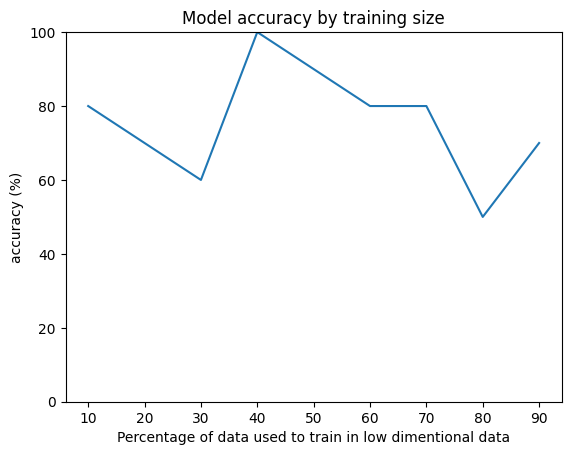

In [4]:
plt.title('Model accuracy by training size');
plt.plot( accuracies.transpose());
plt.ylim([0,100]);
plt.xticks(np.arange(9),percentage_data);
plt.xlabel('Percentage of data used to train in low dimentional data');
plt.ylabel('accuracy (%)');

In [5]:
#task 2

accuracies = np.zeros(9)

out = output_variable
inp = input_variables[-1]

for i,train in enumerate(train_ranges):
    
    model= p_trainer.fit(inp[train],out[train])
    accuracies[i] = model.score(inp[test],out[test])

accuracies*=100

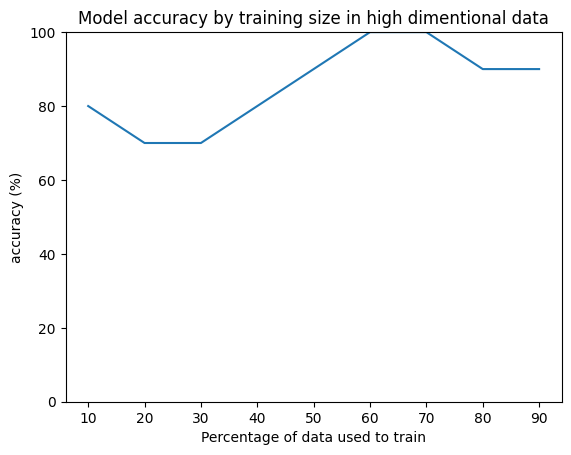

In [6]:
plt.title('Model accuracy by training size in high dimentional data');
plt.plot( accuracies.transpose());
plt.ylim([0,100]);
plt.xticks(np.arange(9),percentage_data);
plt.xlabel('Percentage of data used to train');
plt.ylabel('accuracy (%)');

In [7]:
#task 3

precisions = np.zeros(9)
recalls = np.zeros(9)
f1s = np.zeros(9)
sensitivities = np.zeros(9)
specificities = np.zeros(9)

out = output_variable
inp = input_variables[0]

for i,train in enumerate(train_ranges):
    
    model= p_trainer.fit(inp[train],out[train])

    p = model.predict(inp[test])
    t = out[test]

    tp = sum(p[p==1]==t[p==1])
    fp = sum(p[p==1]!=t[p==1])
    tn = sum(p[p==0]==t[p==0])
    fn = sum(p[p==0]!=t[p==0])

    precisions[i] = tp/(tp+fp) *100
    recalls[i] = tp/(tp+fn) *100
    f1s[i] = sklearn.metrics.f1_score(t,p) *100
    specificities[i] = tn/(tn+fp) *100
    sensitivities[i] = tp/(tp+fn) *100  #sensitivity and recall are the same thing


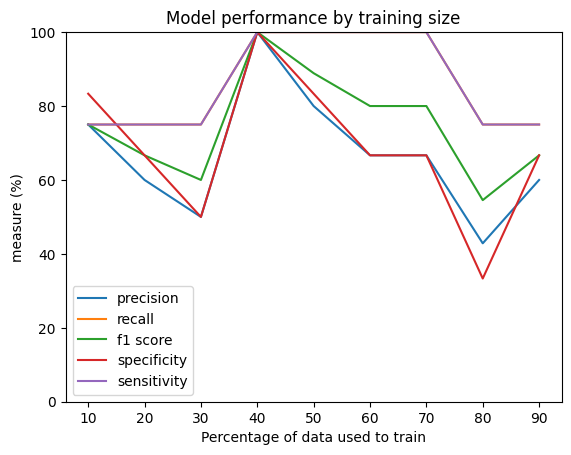

In [8]:
plt.title('Model performance by training size');
plt.plot(precisions);
plt.plot(recalls);
plt.plot(f1s);
plt.plot(specificities);
plt.plot(sensitivities);

plt.legend(['precision','recall','f1 score','specificity','sensitivity'])

plt.ylim([0,100]);
plt.xticks(np.arange(9),percentage_data);
plt.xlabel('Percentage of data used to train');
plt.ylabel('measure (%)');

In [9]:
#task 4

predictions = np.zeros(100)
splits_n = 10
splitter = sklearn.model_selection.KFold(n_splits=splits_n, shuffle=False)

out = output_variable
inp = input_variables[0]

index_generator = splitter.split(inp,out)

for train,test in index_generator:
    
    model= p_trainer.fit(inp[train],out[train])
    predictions[test] = model.predict(inp[test])

c_mat = sklearn.metrics.confusion_matrix(out,predictions)

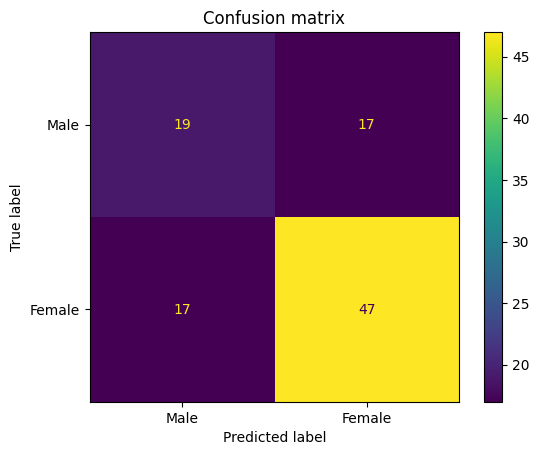

In [10]:
sklearn.metrics.ConfusionMatrixDisplay(c_mat).plot();
plt.title('Confusion matrix');
plt.xticks([0,1],['Male','Female']);
plt.yticks([0,1],['Male','Female']);

In [11]:
#task 5

predictions = np.zeros(100)
splits_n = 10
splitter = sklearn.model_selection.KFold(n_splits=splits_n, shuffle=False)

out = output_variable
inp = input_variables[0]

index_generator = splitter.split(inp,out)

for train,test in index_generator:
    
    model= p_trainer.fit(inp[train],out[train])
    predictions[test] = model.predict_proba(inp[test])[:,1]

c_curve = sklearn.calibration.calibration_curve(out,predictions)

Text(0, 0.5, 'observed proportion')

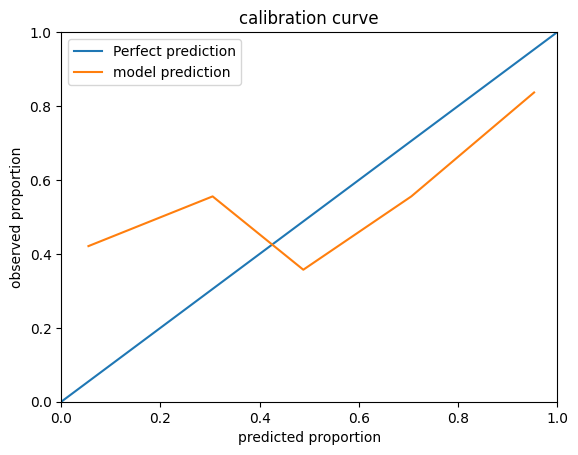

In [12]:
x = np.arange(0,1.25,0.25)
plt.plot(x,x)
plt.plot(c_curve[1],c_curve[0])
plt.title("calibration curve")
plt.ylim([0,1])
plt.xlim([0,1])
plt.legend(['Perfect prediction','model prediction'])
plt.xlabel('predicted proportion')
plt.ylabel('observed proportion')